In [1]:
from torch.utils.data import Dataset,DataLoader
import torch
from torch import tensor
import torch.nn as nn
import torch.nn.functional as F
import glob
import os
from functools import partial
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import optim
from tqdm import tqdm
import numpy as np
from refinement_module import UNet
from torch.optim.lr_scheduler import OneCycleLR
import random
from Datasets import WeihToI3
from model import UNet

/home/sow/venv/prism-uda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = WeihToI3(mode="val")

In [3]:
a = ds[1][0].float().unsqueeze(0)

In [4]:
a.shape

torch.Size([1, 1, 256, 256])

In [5]:
ds[1][1].shape

torch.Size([1, 256, 256])

In [6]:
model = UNet(2,2)

In [7]:
model(a,a).shape

torch.Size([1, 2, 256, 256])

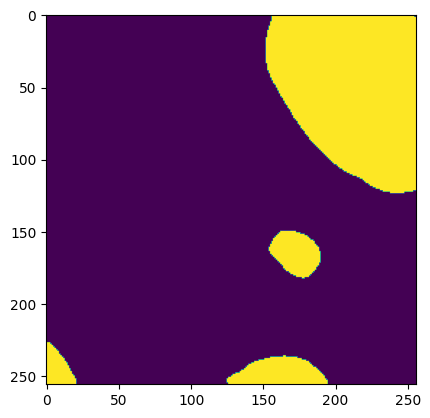

In [8]:
plt.imshow(a.squeeze())

In [8]:
def compute_iou(preds:torch.Tensor,gt:torch.Tensor,num_classes=2,ignore_index=255):
    mask = gt != ignore_index
    preds = preds[mask]
    gt = gt[mask]

    iou_list = []

    for cls in range(num_classes):
        cls_in_preds = preds == cls
        cls_in_gt = gt == cls

        intersection = (cls_in_preds & cls_in_gt).sum().item()
        union = (cls_in_preds | cls_in_gt).sum().item()

        if union == 0:
            iou_list.append(0)
            continue  # this class is not present in gt

        iou = intersection / union
        iou_list.append(iou)

    if not iou_list:
        raise ValueError("No class found in this predictions")
    return sum(iou_list) / len(iou_list)

def plot(pl:torch.Tensor,
         sam:torch.Tensor,
         preds:torch.Tensor,
         gt:torch.Tensor,
         epoch,
         batch_id,
         model_name,
         dataset_type,mask_type
         ):
    if batch_id % 200==0:
        pl = pl.squeeze().detach().cpu().numpy()
        sam = sam.squeeze().detach().cpu().numpy()
        preds = preds.squeeze().detach().cpu().numpy()
        gt = gt.squeeze().detach().cpu().numpy()

        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

        axes[0].imshow(pl)
        axes[0].set_title("Pseudo label de l'EMA")

        axes[1].imshow(sam)
        axes[1].set_title("SAM")

        axes[2].imshow(preds)
        axes[2].set_title("Prédictions du raffineur")

        axes[3].imshow(gt)
        axes[3].set_title("Ground truth")

        plt.tight_layout()

        os.makedirs(f"refinement_results/{model_name}_train_on_{dataset_type}_mask_type_{mask_type}/debug", exist_ok=True)
        plt.savefig(f"refinement_results/{model_name}_train_on_{dataset_type}_mask_type_{mask_type}/debug/{epoch}_{batch_id}.png")
        plt.close(fig)

def save_metrics(train_losses,val_losses,train_m_iou,val_m_iou,model_name,dataset_type,mask_type):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(train_m_iou, label="Train mIoU")
    plt.plot(val_m_iou, label="Val mIoU")
    plt.legend()
    plt.title("Mean IoU")
    plt.savefig(f"refinement_results/{model_name}_train_on_{dataset_type}_mask_type_{mask_type}/metrics.png")
    plt.close()


def one_batch(model,model_name,epoch,device,
              batch,batch_id,
              optimizer:optim.Optimizer,
              loss_function:nn.CrossEntropyLoss,
              dataset_type:str,mask_type,
              on_training=True):
    model.train() if on_training else model.eval()
    if dataset_type == "i3":
        pl,sam,gt = batch
        pl,sam,gt = pl.float(),sam.float(),gt.long()
        pl,sam,gt = pl.to(device),sam.to(device),gt.to(device)
        preds = model(pl,sam)
    else :
        sam,gt = batch
        sam,gt = sam.float(),gt.long()
        sam,gt = sam.to(device),gt.to(device)
        preds = model(sam,sam) 
    loss = loss_function(preds,gt.squeeze(1))
    if on_training:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    preds = preds.argmax(dim=1)

    iou = compute_iou(preds,gt.squeeze(1))

    if not on_training :
        if dataset_type == "i3":
            plot(pl,sam,preds,gt,epoch,batch_id,model_name,dataset_type,mask_type)
        else :
            plot(sam,sam,preds,gt,epoch,batch_id,model_name,dataset_type,mask_type)

    return loss.item(), iou


def one_epoch(model,model_name,epoch,device,
              dataloader: DataLoader,
              optimizer:optim.Optimizer,
              loss_function:nn.CrossEntropyLoss,
              dataset_type:str,mask_type,
              on_training=True):
    train_loss = 0
    m_iou = 0
    N = 0
    for batch_id,batch in enumerate(dataloader):
        loss,iou = one_batch(model=model,model_name=model_name,mask_type=mask_type,epoch=epoch,device=device,batch=batch,batch_id=batch_id,optimizer=optimizer,dataset_type=dataset_type, loss_function=loss_function,on_training=on_training)
        if batch_id % 100 == 0: 
            print("train_loss = ",loss," epoch = ",epoch," batch_id = ",batch_id)
        train_loss = train_loss + loss
        m_iou = m_iou + iou
        N += 1
    return train_loss / N, m_iou / N

def train(model,max_epochs,lr,train_dl,val_dl,model_name,dataset_type,mask_type):
    train_losses = []
    val_losses = []
    train_m_iou = []
    val_m_iou = []
    device = "cuda" #if torch.cuda.is_available() else "cpu"
    best_val_iou = 1000

    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(),lr=lr)
    weight = torch.tensor([1.,5.],device=device)  
    loss_function = nn.CrossEntropyLoss(ignore_index=255)
    progress_bar = tqdm(range(max_epochs))

    if dataset_type == "i3":
        train_dataset = "i3"
        val_dataset = "i3"
    else:
        train_dataset = "weih"
        val_dataset = "weih"
    for epoch in progress_bar:
        train_loss, train_iou = one_epoch(model=model,model_name=model_name,mask_type=mask_type,epoch=epoch,device=device,dataloader=train_dl,optimizer=optimizer,dataset_type=train_dataset,loss_function=loss_function,on_training=True)
        train_losses.append(train_loss)
        train_m_iou.append(train_iou)
        with torch.no_grad():
            val_loss, val_iou = one_epoch(model=model,model_name=model_name,mask_type=mask_type,epoch=epoch,device=device,dataloader=val_dl,optimizer=optimizer,dataset_type=val_dataset,loss_function=loss_function,on_training=False)
            val_losses.append(val_loss)
            val_m_iou.append(val_iou)
        progress_bar.set_postfix(dict(train_loss=train_loss,train_iou=train_iou,val_loss=val_loss,val_iou=val_iou))
        # save losses and IoU
        save_metrics(train_losses,val_losses,train_m_iou,val_m_iou,model_name,dataset_type,mask_type=mask_type)
        if val_iou < best_val_iou:
            best_val_iou = val_iou
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_iou': val_iou
            }, f"refinement_results/{model_name}_train_on_{dataset_type}_mask_type_{mask_type}/best_checkpoint.pth")

In [9]:
train_ds = WeihToI3(mode="train",)
val_ds = WeihToI3(mode="val",)
train_dl = DataLoader(train_ds,2,True,num_workers=8)
val_dl = DataLoader(val_ds,1,False,num_workers=8)

In [10]:
train_ds[1][0].unique()

tensor([0, 1], dtype=torch.uint8)

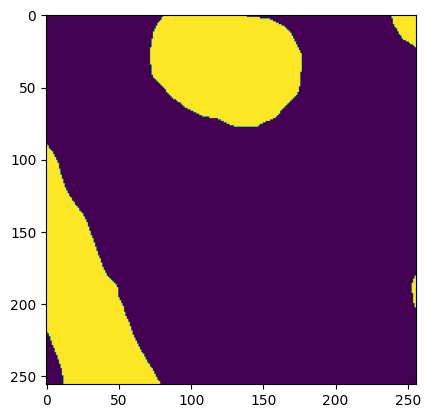

In [11]:
plt.imshow(train_ds[0][2].squeeze())

In [12]:
len(train_dl),len(val_dl)

(4182, 3585)

In [13]:
torch.cuda.empty_cache()

In [14]:
model = UNet(2,2)

In [ ]:
train(model,50,1e-4,train_dl,val_dl,"Refine","i3","colour")

  0%|          | 0/50 [00:00<?, ?it/s]

train_loss =  24.470443725585938  epoch =  0  batch_id =  0
train_loss =  0.17944014072418213  epoch =  0  batch_id =  100
train_loss =  0.5937877297401428  epoch =  0  batch_id =  200
train_loss =  0.027424782514572144  epoch =  0  batch_id =  300
train_loss =  0.12890732288360596  epoch =  0  batch_id =  400
train_loss =  0.2820359170436859  epoch =  0  batch_id =  500
train_loss =  0.17693790793418884  epoch =  0  batch_id =  600
train_loss =  0.12732672691345215  epoch =  0  batch_id =  700
train_loss =  0.17192935943603516  epoch =  0  batch_id =  800
train_loss =  0.38250288367271423  epoch =  0  batch_id =  900
train_loss =  0.6973953247070312  epoch =  0  batch_id =  1000
train_loss =  0.1762378215789795  epoch =  0  batch_id =  1100
train_loss =  0.0005974449450150132  epoch =  0  batch_id =  1200
train_loss =  0.7872117757797241  epoch =  0  batch_id =  1300
train_loss =  0.33298516273498535  epoch =  0  batch_id =  1400
train_loss =  0.10853752493858337  epoch =  0  batch_id

  2%|▏         | 1/50 [06:56<5:40:08, 416.50s/it, train_loss=0.266, train_iou=0.669, val_loss=0.152, val_iou=0.642]

train_loss =  0.12584832310676575  epoch =  1  batch_id =  0
train_loss =  0.17034924030303955  epoch =  1  batch_id =  100
train_loss =  0.13262797892093658  epoch =  1  batch_id =  200
train_loss =  0.26223671436309814  epoch =  1  batch_id =  300
train_loss =  0.09348039329051971  epoch =  1  batch_id =  400
train_loss =  0.12309715151786804  epoch =  1  batch_id =  500
train_loss =  0.01696350984275341  epoch =  1  batch_id =  600
train_loss =  0.043440841138362885  epoch =  1  batch_id =  700
train_loss =  0.22031399607658386  epoch =  1  batch_id =  800
train_loss =  0.17370346188545227  epoch =  1  batch_id =  900
train_loss =  0.13070987164974213  epoch =  1  batch_id =  1000
train_loss =  0.1860068291425705  epoch =  1  batch_id =  1100
train_loss =  0.05887005105614662  epoch =  1  batch_id =  1200
train_loss =  0.11644235253334045  epoch =  1  batch_id =  1300
train_loss =  0.032629672437906265  epoch =  1  batch_id =  1400
train_loss =  0.2240218073129654  epoch =  1  batch

  4%|▍         | 2/50 [13:03<5:09:52, 387.34s/it, train_loss=0.145, train_iou=0.714, val_loss=0.14, val_iou=0.661] 

train_loss =  0.3488041162490845  epoch =  2  batch_id =  0
train_loss =  0.07070843875408173  epoch =  2  batch_id =  100
train_loss =  0.09459947049617767  epoch =  2  batch_id =  200
train_loss =  0.1336037516593933  epoch =  2  batch_id =  300
train_loss =  0.309194415807724  epoch =  2  batch_id =  400
train_loss =  0.023541167378425598  epoch =  2  batch_id =  500
train_loss =  0.08993428200483322  epoch =  2  batch_id =  600
train_loss =  0.09594294428825378  epoch =  2  batch_id =  700
train_loss =  0.09874247014522552  epoch =  2  batch_id =  800
train_loss =  0.1488821655511856  epoch =  2  batch_id =  900
train_loss =  0.1401548832654953  epoch =  2  batch_id =  1000
train_loss =  0.14562562108039856  epoch =  2  batch_id =  1100
train_loss =  0.24172332882881165  epoch =  2  batch_id =  1200
train_loss =  0.18693935871124268  epoch =  2  batch_id =  1300
train_loss =  0.1442374885082245  epoch =  2  batch_id =  1400
train_loss =  0.0721527561545372  epoch =  2  batch_id =  

  6%|▌         | 3/50 [19:42<5:07:34, 392.65s/it, train_loss=0.137, train_iou=0.728, val_loss=0.131, val_iou=0.649]

train_loss =  0.06819324940443039  epoch =  3  batch_id =  0
train_loss =  0.005910626612603664  epoch =  3  batch_id =  100
train_loss =  0.04596182703971863  epoch =  3  batch_id =  200
train_loss =  0.08340185135602951  epoch =  3  batch_id =  300
train_loss =  0.11384819447994232  epoch =  3  batch_id =  400
train_loss =  0.07317471504211426  epoch =  3  batch_id =  500
train_loss =  0.767841100692749  epoch =  3  batch_id =  600
train_loss =  0.16077382862567902  epoch =  3  batch_id =  700
train_loss =  0.15893372893333435  epoch =  3  batch_id =  800
train_loss =  0.06921172887086868  epoch =  3  batch_id =  900
train_loss =  0.147182434797287  epoch =  3  batch_id =  1000
train_loss =  0.3395751416683197  epoch =  3  batch_id =  1100
train_loss =  0.06804662942886353  epoch =  3  batch_id =  1200
train_loss =  0.06168828159570694  epoch =  3  batch_id =  1300
train_loss =  0.010182450525462627  epoch =  3  batch_id =  1400
train_loss =  0.028106827288866043  epoch =  3  batch_i

  8%|▊         | 4/50 [26:08<4:59:04, 390.09s/it, train_loss=0.129, train_iou=0.736, val_loss=0.126, val_iou=0.664]

train_loss =  0.12484438717365265  epoch =  4  batch_id =  0
train_loss =  0.39045530557632446  epoch =  4  batch_id =  100
train_loss =  0.06468991190195084  epoch =  4  batch_id =  200
train_loss =  0.02324780635535717  epoch =  4  batch_id =  300
train_loss =  0.04022602364420891  epoch =  4  batch_id =  400
train_loss =  0.11946172267198563  epoch =  4  batch_id =  500
train_loss =  0.0038027330301702023  epoch =  4  batch_id =  600
train_loss =  0.08225692808628082  epoch =  4  batch_id =  700
train_loss =  0.09041421115398407  epoch =  4  batch_id =  800
train_loss =  0.10972797870635986  epoch =  4  batch_id =  900
train_loss =  0.039762891829013824  epoch =  4  batch_id =  1000
train_loss =  0.016337687149643898  epoch =  4  batch_id =  1100
train_loss =  0.21571491658687592  epoch =  4  batch_id =  1200
train_loss =  0.282138854265213  epoch =  4  batch_id =  1300
train_loss =  0.005633161403238773  epoch =  4  batch_id =  1400
train_loss =  0.132225900888443  epoch =  4  batc

 10%|█         | 5/50 [32:50<4:55:44, 394.32s/it, train_loss=0.164, train_iou=0.702, val_loss=0.142, val_iou=0.661]

train_loss =  0.01656506024301052  epoch =  5  batch_id =  0
train_loss =  0.07257646322250366  epoch =  5  batch_id =  100
train_loss =  0.006207382306456566  epoch =  5  batch_id =  200
train_loss =  0.22155076265335083  epoch =  5  batch_id =  300
train_loss =  0.09788917750120163  epoch =  5  batch_id =  400
train_loss =  0.3085687756538391  epoch =  5  batch_id =  500
train_loss =  0.0851423442363739  epoch =  5  batch_id =  600
train_loss =  0.1630101501941681  epoch =  5  batch_id =  700
train_loss =  0.3851888179779053  epoch =  5  batch_id =  800
train_loss =  0.47444847226142883  epoch =  5  batch_id =  900
train_loss =  0.08366916328668594  epoch =  5  batch_id =  1000
train_loss =  0.015833662822842598  epoch =  5  batch_id =  1100
train_loss =  0.1877758502960205  epoch =  5  batch_id =  1200
train_loss =  0.00817926786839962  epoch =  5  batch_id =  1300
train_loss =  0.6015812754631042  epoch =  5  batch_id =  1400
train_loss =  0.2538363039493561  epoch =  5  batch_id =

 12%|█▏        | 6/50 [39:19<4:47:51, 392.54s/it, train_loss=0.128, train_iou=0.739, val_loss=0.135, val_iou=0.664]

train_loss =  0.0005116676911711693  epoch =  6  batch_id =  0
train_loss =  0.062341876327991486  epoch =  6  batch_id =  100
train_loss =  0.3855554461479187  epoch =  6  batch_id =  200
train_loss =  0.04212779551744461  epoch =  6  batch_id =  300
train_loss =  0.058580171316862106  epoch =  6  batch_id =  400
train_loss =  0.18661314249038696  epoch =  6  batch_id =  500
train_loss =  0.04184376448392868  epoch =  6  batch_id =  600
train_loss =  0.2182963490486145  epoch =  6  batch_id =  700
train_loss =  0.11848410964012146  epoch =  6  batch_id =  800
train_loss =  0.1051667332649231  epoch =  6  batch_id =  900
train_loss =  0.06226736307144165  epoch =  6  batch_id =  1000
train_loss =  0.2809033989906311  epoch =  6  batch_id =  1100


 12%|█▏        | 6/50 [40:42<4:58:29, 407.04s/it, train_loss=0.128, train_iou=0.739, val_loss=0.135, val_iou=0.664]


KeyboardInterrupt: 